<a href="https://colab.research.google.com/github/dmburns1729/Class-Files/blob/main/Intro_to_Gradient_Boosting_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [ ]:
# Get data
df = pd.read_excel('/content/census_income.xlsx')
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0.0,39.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,1.0,50.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,2.0,38.0,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,3.0,53.0,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,4.0,28.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [ ]:
# Make a copy of the data for cleaning
df_clean=df.copy()

In [ ]:
df_clean = df_clean.drop(columns = 'Unnamed: 0')

In [ ]:
df_clean.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


Prepare your dataset for modeling.

Remember to:
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  object 
 2   education       32561 non-null  object 
 3   marital-status  32561 non-null  object 
 4   occupation      32561 non-null  object 
 5   relationship    32561 non-null  object 
 6   race            32561 non-null  object 
 7   sex             32561 non-null  object 
 8   capital-gain    32561 non-null  float64
 9   capital-loss    32561 non-null  float64
 10  hours-per-week  32561 non-null  float64
 11  native-country  32561 non-null  object 
 12  income-class    32561 non-null  object 
dtypes: float64(4), object(9)
memory usage: 3.2+ MB


In [ ]:
df_clean.duplicated().sum()

3465

In [ ]:
df_clean.isna().sum()
# Shows missing values by column

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

In [ ]:
# Check categorical columns for consistancy
# select only object columns
categoricals = df_clean.select_dtypes(include='object')

# check value counts for each object column
for col in categoricals.columns:
  print(col)
  print(categoricals[col].value_counts(), '\n')

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64 

education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64 

marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64 

occupation
Prof-specialty       4140
Craft-repair         409

In [ ]:
df_clean['income-class'].value_counts()

<=50K    24720
>50K      7841
Name: income-class, dtype: int64

In [ ]:
# Significantly unbalanced.  Will run classificaiton first without balancing
# Will try again with balancing if the data is off

In [ ]:
df_clean.describe()

,age,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1077.648844,87.303830,40.437456
std,13.640433,7385.292085,402.960219,12.347429
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [ ]:
# split X and y, we are predicting drug
X = df_clean.drop(columns=['income-class'])
y = df_clean['income-class']

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
smote = SMOTE()



#instantiate the StandardScaler, OneHotEncoder, and Imputers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
# Setup the pipelines for the numeric and categorical data

# We don't strictly need the imputer since we dealt with the
# unknown BP values by filling in unknown when cleaning the data and
# we dropped age.
#
# However, I ran this model about a million times in a bunch of different ways until
# I figured to drop age, gender, and that I could fill the BP data with unknown
# without causing data leakage.
#
# I could just skip the imputer and add scaler and ohe to the column selector.
# however, I want to flexibility if I want to continue to tinker with this model

num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(freq_imputer, ohe)

# I used scaler to normalize the numeric data
# I chose ohe to encode the object data.  I would have used the ordinal encoding
# but I included an "unknown" for blood pressure and that wouldn't work for ordinal

# Selectors
num_selector = make_column_selector(dtype_include='number')
nom_selector = make_column_selector(dtype_include='object')

# Setup the tuples to pair the processors with the make column selectors

numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, nom_selector)

# Instantiate the make column transformer
preprocessor = make_column_transformer(numeric_tuple,nominal_tuple,remainder='drop')

In [ ]:
# define the evaluate_classiffication function here.  I shameless ripped this idea
# off from the code along notebook.

def evaluate_classiffication(lgr_pipe, X_test, y_test, label="Test Data"):
  test_preds = lgr_pipe.predict(X_test)


   ## Print classification report for the test data
  print('---'*20)
  print(f"CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data
  print(classification_report(y_test, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax=axes[1])
  plt.show()



# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, accuracy_score, classification_report)



#Import RandomOverSampling
from imblearn.over_sampling import RandomOverSampler
#Create an oversampling pipeline
over_sampler = RandomOverSampler()


------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.96      0.92      6214
        >50K       0.81      0.57      0.67      1927

    accuracy                           0.87      8141
   macro avg       0.84      0.77      0.79      8141
weighted avg       0.86      0.87      0.86      8141



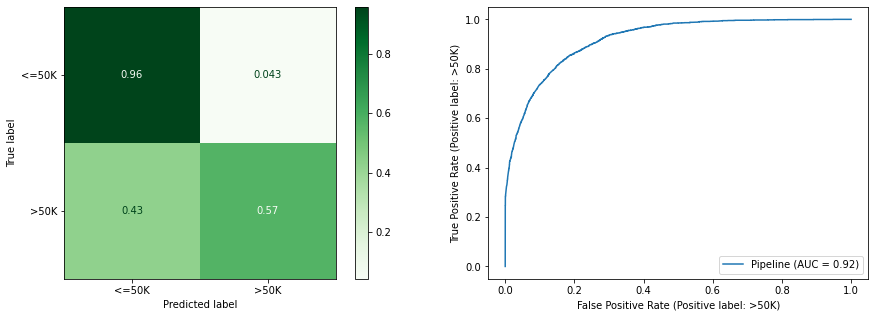

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91     18506
        >50K       0.81      0.57      0.67      5914

    accuracy                           0.86     24420
   macro avg       0.84      0.76      0.79     24420
weighted avg       0.86      0.86      0.86     24420



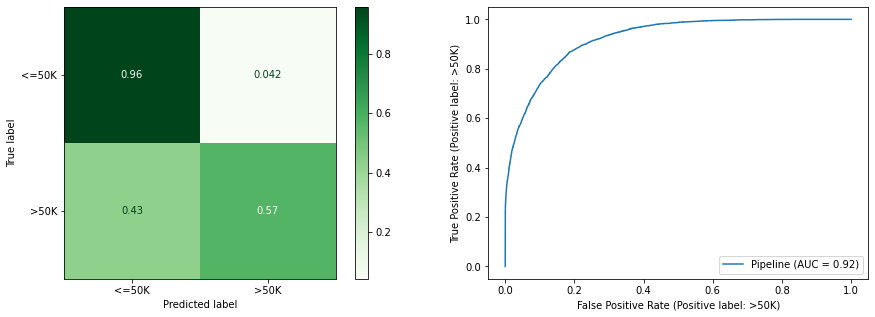

CPU times: user 6.76 s, sys: 41.1 ms, total: 6.8 s
Wall time: 7.16 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)
evaluate_classiffication(xgb_pipe, X_test, y_test, label="Test Data")
evaluate_classiffication(xgb_pipe, X_train, y_train, label="Train Data")

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.82      0.88      6214
        >50K       0.59      0.84      0.69      1927

    accuracy                           0.82      8141
   macro avg       0.77      0.83      0.78      8141
weighted avg       0.86      0.82      0.83      8141



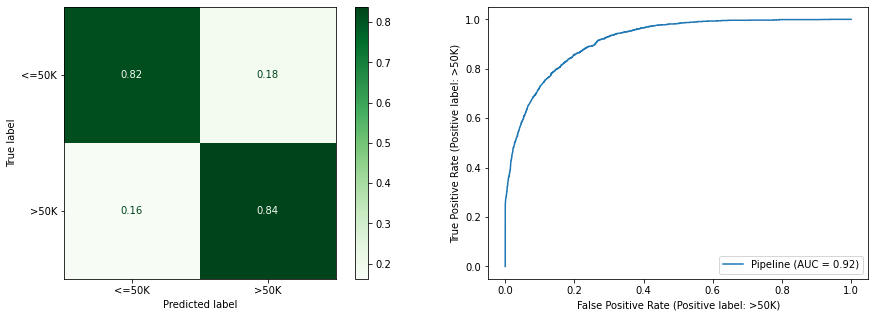

CPU times: user 8.58 s, sys: 132 ms, total: 8.71 s
Wall time: 8.5 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, smote, xgb)
xgb_pipe.fit(X_train, y_train)
evaluate_classiffication(xgb_pipe, X_test, y_test, label="Test Data")


------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.95      0.81      0.87      6214
        >50K       0.58      0.86      0.69      1927

    accuracy                           0.82      8141
   macro avg       0.76      0.83      0.78      8141
weighted avg       0.86      0.82      0.83      8141



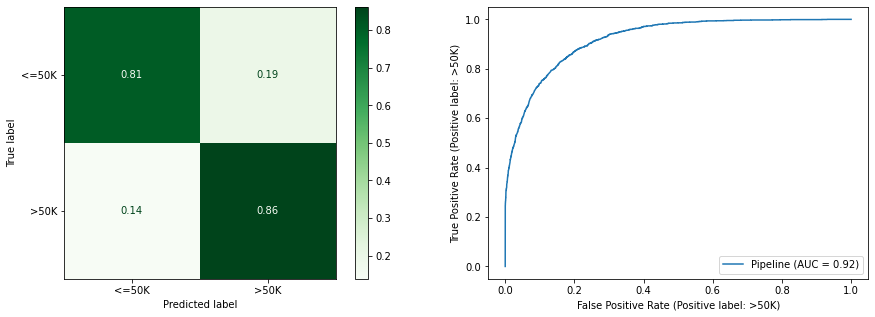

CPU times: user 7.93 s, sys: 32.9 ms, total: 7.96 s
Wall time: 8.48 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, over_sampler, xgb)
xgb_pipe.fit(X_train, y_train)
evaluate_classiffication(xgb_pipe, X_test, y_test, label="Test Data")


Which target class is your model better at predicting?  Is it significantly overfit?

**Significantly under predicts those making over 50K probably because imbalanced class. Smote and oversampler help**

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6214
        >50K       0.78      0.67      0.72      1927

    accuracy                           0.88      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.88      0.87      8141



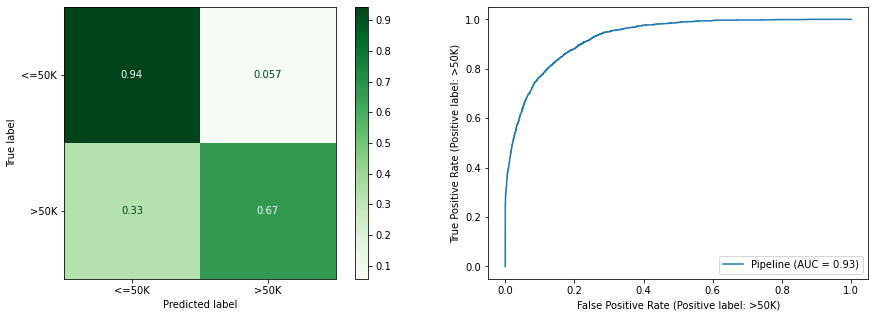

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.91      0.95      0.93     18506
        >50K       0.81      0.69      0.75      5914

    accuracy                           0.89     24420
   macro avg       0.86      0.82      0.84     24420
weighted avg       0.88      0.89      0.88     24420



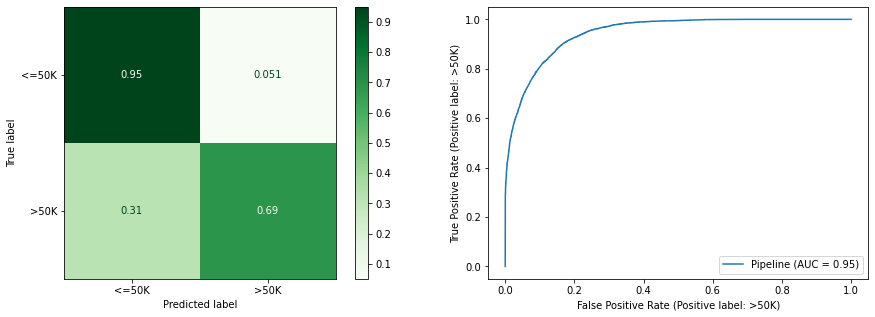

CPU times: user 2.98 s, sys: 35.1 ms, total: 3.02 s
Wall time: 3.07 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

lgbm = LGBMClassifier()

lgbm_pipe = make_pipeline(preprocessor,lgbm)
lgbm_pipe.fit(X_train, y_train)
evaluate_classiffication(lgbm_pipe, X_test, y_test, label="Test Data")
evaluate_classiffication(lgbm_pipe, X_train, y_train, label="Train Data")

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.93      0.88      0.91      6214
        >50K       0.68      0.78      0.73      1927

    accuracy                           0.86      8141
   macro avg       0.80      0.83      0.82      8141
weighted avg       0.87      0.86      0.86      8141



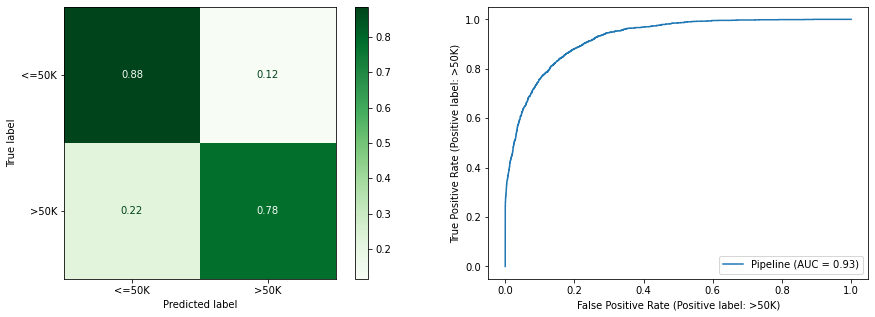

CPU times: user 3.48 s, sys: 138 ms, total: 3.62 s
Wall time: 3.49 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

lgbm = LGBMClassifier()

lgbm_pipe = make_pipeline(preprocessor,smote, lgbm)
lgbm_pipe.fit(X_train, y_train)
evaluate_classiffication(lgbm_pipe, X_test, y_test, label="Test Data")

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.95      0.83      0.88      6214
        >50K       0.60      0.86      0.71      1927

    accuracy                           0.83      8141
   macro avg       0.78      0.84      0.80      8141
weighted avg       0.87      0.83      0.84      8141



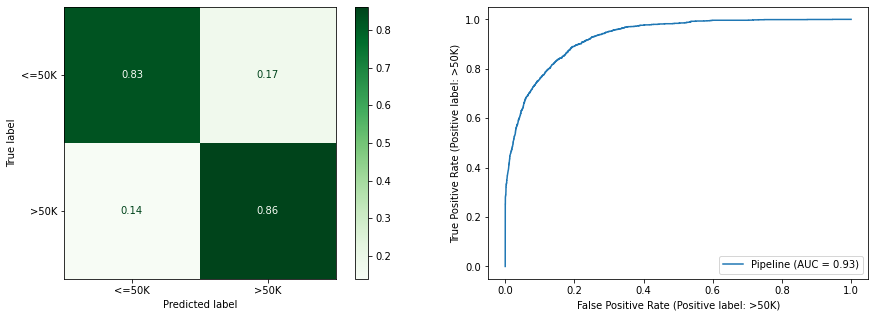

CPU times: user 1.6 s, sys: 23.1 ms, total: 1.63 s
Wall time: 1.79 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier

lgbm = LGBMClassifier()

lgbm_pipe = make_pipeline(preprocessor,over_sampler, lgbm)
lgbm_pipe.fit(X_train, y_train)
evaluate_classiffication(lgbm_pipe, X_test, y_test, label="Test Data")

## GradientBoostingClassifier

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.83      0.88      6214
        >50K       0.60      0.82      0.69      1927

    accuracy                           0.83      8141
   macro avg       0.77      0.83      0.79      8141
weighted avg       0.86      0.83      0.84      8141



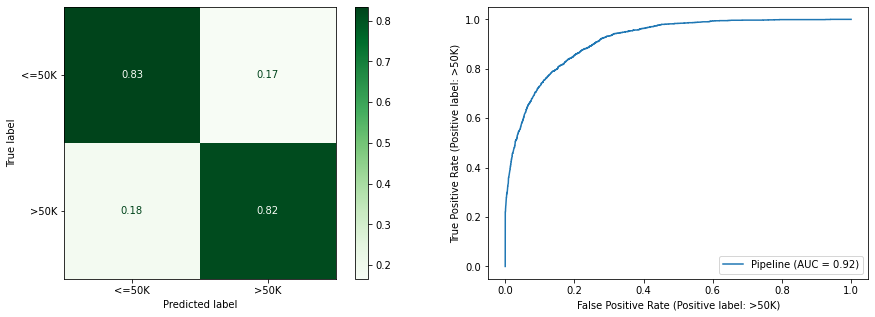

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.83      0.88     18506
        >50K       0.61      0.83      0.70      5914

    accuracy                           0.83     24420
   macro avg       0.77      0.83      0.79     24420
weighted avg       0.86      0.83      0.84     24420



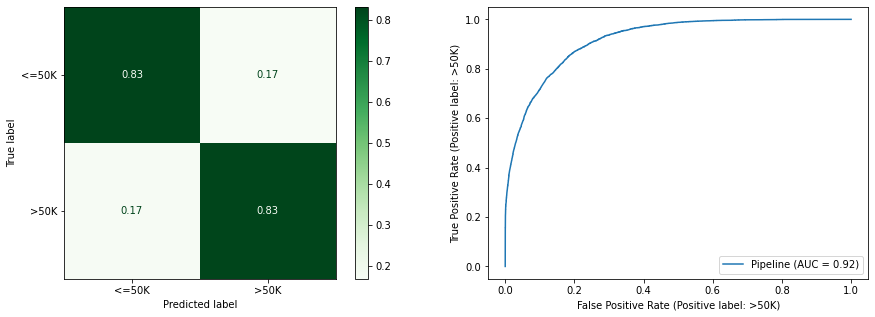

CPU times: user 16.6 s, sys: 156 ms, total: 16.7 s
Wall time: 16.6 s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier
gbc = GradientBoostingClassifier()

gbc_pipe = make_pipeline(preprocessor, smote, gbc)
gbc_pipe.fit(X_train, y_train)
evaluate_classiffication(gbc_pipe, X_test, y_test, label="Test Data")
evaluate_classiffication(gbc_pipe, X_train, y_train, label="Train Data")



# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [ ]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8522cea610>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                 

In [ ]:
#create and visualize our parameter grid
param_grid = {'lgbmclassifier__max_depth': [1,2,3,4,5,6,7,8,9,10],
              'lgbmclassifier__num_leaves': [5,10,15,20,25,30,35,40,45,50],
              'lgbmclassifier__n_estimators': [80,100,120,140,160,180,200]
              }


In [ ]:
model = lgbm_pipe
lgbm_pipe_grid_search = GridSearchCV(model, param_grid)

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6214
        >50K       0.79      0.66      0.72      1927

    accuracy                           0.88      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.88      0.87      8141



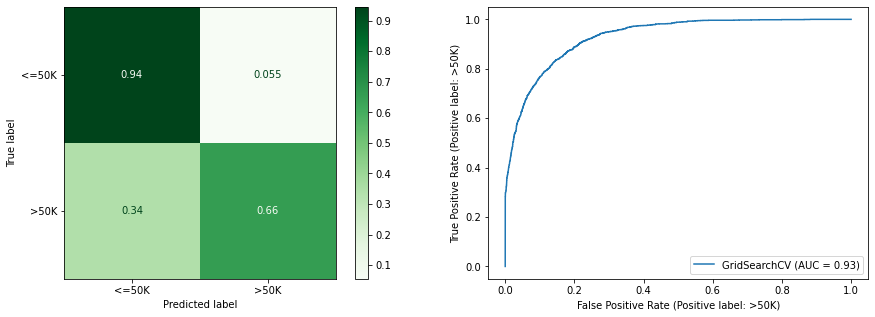

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.95      0.93     18506
        >50K       0.82      0.68      0.74      5914

    accuracy                           0.89     24420
   macro avg       0.86      0.82      0.83     24420
weighted avg       0.88      0.89      0.88     24420



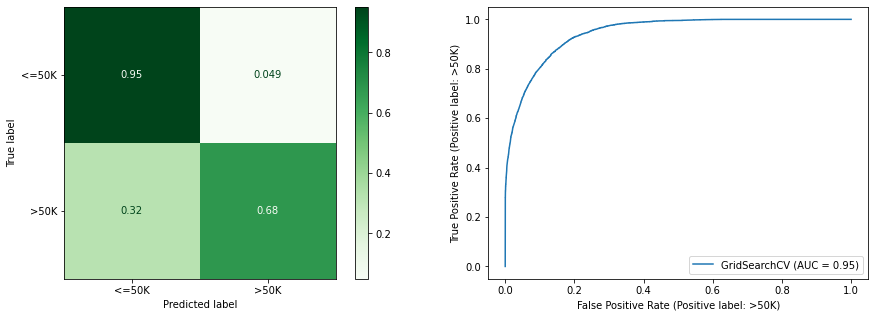

CPU times: user 26min 31s, sys: 15.1 s, total: 26min 46s
Wall time: 26min 52s


In [ ]:
%%time
# Instantiate and fit gradient boosting classifier
lgbm_pipe_grid_search.fit(X_train, y_train)


In [ ]:
#retrieve the best version of the model
best_model_lgbm = lgbm_pipe_grid_search.best_estimator_

#refit the model on the whole training set
best_model_lgbm.fit(X_train, y_train)

#score the model on the test set
best_model_lgbm.score(X_test, y_test)

0.8770421324161651

In [ ]:
best_model_lgbm.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8522c4d250>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                 

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6214
        >50K       0.79      0.66      0.72      1927

    accuracy                           0.88      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.88      0.87      8141



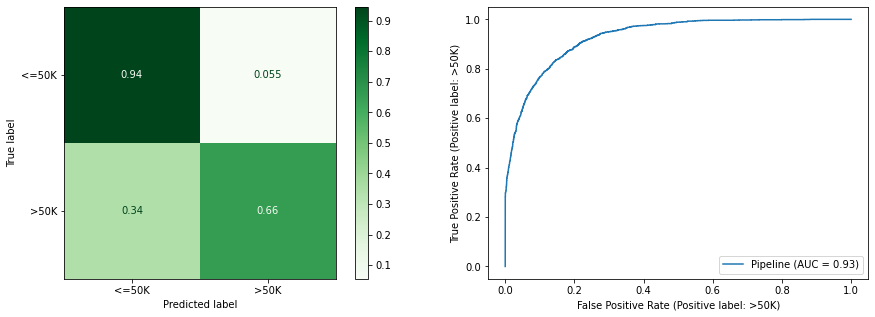

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.95      0.93     18506
        >50K       0.82      0.68      0.74      5914

    accuracy                           0.89     24420
   macro avg       0.86      0.82      0.83     24420
weighted avg       0.88      0.89      0.88     24420



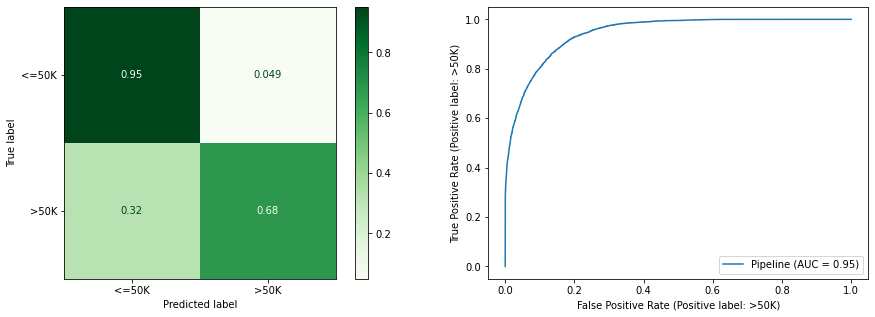

In [ ]:
evaluate_classiffication(best_model_lgbm, X_test, y_test, label="Test Data")
evaluate_classiffication(best_model_lgbm, X_train, y_train, label="Train Data")



Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

# Evaluation

The tuned lgbm model did the best with a test accuracy of .88.  The model was not significantly overfit but it was bias against the imbalanced class.  Using smote or over_sampler resulted in a lower accuracy but better prediction of income over 50K

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

